Why would you ever use a single processor? We have a total of 16. See $man nproc

In [1]:
addprocs(7);

In [3]:
@everywhere using Graphs, Images;

In [7]:
using Gadfly, Base.Test

    +(AbstractArray{T,N},DataArray{T,N}) at /home/elpinguino/.julia/DataArrays/src/operators.jl:326
is ambiguous with: 
    +(AbstractImageDirect{T,N},AbstractArray{T,N}) at /home/elpinguino/.julia/Images/src/algorithms.jl:18.
To fix, define 
    +(AbstractImageDirect{T,N},DataArray{T,N})
before the new definition.
    +(AbstractArray{T,N},AbstractDataArray{T,N}) at /home/elpinguino/.julia/DataArrays/src/operators.jl:349
is ambiguous with: 
    +(AbstractImageDirect{T,N},AbstractArray{T,N}) at /home/elpinguino/.julia/Images/src/algorithms.jl:18.
To fix, define 
    +(AbstractImageDirect{T,N},AbstractDataArray{T,N})
before the new definition.
    -(AbstractArray{T,N},DataArray{T,N}) at /home/elpinguino/.julia/DataArrays/src/operators.jl:326
is ambiguous with: 
    -(AbstractImageDirect{T,N},AbstractArray{T,N}) at /home/elpinguino/.julia/Images/src/algorithms.jl:35.
To fix, define 
    -(AbstractImageDirect{T,N},DataArray{T,N})
before the new definition.
    -(AbstractDataArray{T,N},Abst

We test a few methods such that our code doesn't run like "research code". The idea is to build a random, binary matrix representing forest presence or absence. First We try an approach using Images.jl library to classify groups of pixels in a matrix.

In [4]:
@everywhere function collect_groups(labels)
 groups = [Int[] for i = 1:maximum(labels)]
 for (i,l) in enumerate(labels)
 if l != 0
 push!(groups[l], i)
 end
 end
 groups
end

In [4]:
function alternateVersion(mat::BitArray{2})
 labels = label_components(mat)
 largest = 0
 for i in collect_groups(labels)
 if length(i) > largest largest = length(i) end
 end 
 largest
end

alternateVersion (generic function with 1 method)

The second approach uses Graphs.jl. We convert our binary matrix into a graph and then employ graph techniques to find connected pixels.

In [5]:
# Row major indexing
@everywhere function indexToNode(i,j,n)
 (i - 1)n + j
end

@test indexToNode(1,1,4) == 1
@test indexToNode(2,1,4) == 5
@test indexToNode(3,3,4) == 11

In [6]:
@everywhere function matToGraph(A)
 g = simple_graph(length(A), is_directed = false)
 m = size(A,1)
 n = size(A,2)
 for i = 1:m, j=1:n
 if A[i,j]
 node = indexToNode(i,j,n)
 # Check above
 if i - 1 > 0 && A[i - 1, j]
 add_edge!(g, node, indexToNode(i - 1, j, n))
 end
 # Check below
 if i + 1 <= m && A[i + 1, j]
 add_edge!(g, node, indexToNode(i + 1, j, n))
 end
 # Check left
 if j - 1 > 0 && A[i, j - 1]
 add_edge!(g, node, indexToNode(i, j - 1, n))
 end
 # Check right
 if j + 1 <= n && A[i, j + 1]
 add_edge!(g, node, indexToNode(i, j + 1, n))
 end
 end
 end
 g
end

In [7]:
@everywhere function getLargestComponent(g::GenericGraph)
 largest = 0
 for i in connected_components(g)
 l = length(i)
 if l > largest largest = l end
 end
largest
end

In [8]:
function graphVersion(mat)
 getLargestComponent(matToGraph(mat))
end

graphVersion (generic function with 1 method)

In [9]:
mat = rand(100,100) .<= .5;

Make sure to run a few times such that the code is optimized for speed tests.

In [14]:
@elapsed alternateVersion(mat)

0.000504207

In [17]:
@elapsed graphVersion(mat)

0.084328085

For this problem we'll use the Images.jl version.

In [12]:
@everywhere function getLargestComponent(mat::BitArray{2})
 labels = label_components(mat)
 largest = 0
 for i in collect_groups(labels)
 if length(i) > largest largest = length(i) end
 end 
 largest
end

In [13]:
# Create an n X n model and find the largest average component over r trials 
# given probability increment p
function getAverageConnectedComponents(n::Int, r::Int, p::Float64)
 probs = [p:p:1]
 avgsize = zeros(Float64, length(probs))
 for i in 1:length(probs)
 totalsize = @parallel (+) for j in 1:r
 A = rand(n,n) .<= probs[i]
 getLargestComponent(A)
 end
 avgsize[i] = totalsize / r
 end
 avgsize
end

getAverageConnectedComponents (generic function with 1 method)

Let's see what kind of growth we're looking at

In [20]:
p = 10^-2.0
n = [10, 20, 40, 80, 160]
m = length(n)
time = zeros(m)
for i in 1:m
 time[i] = @elapsed getAverageConnectedComponents(n[i], 100, p)
end

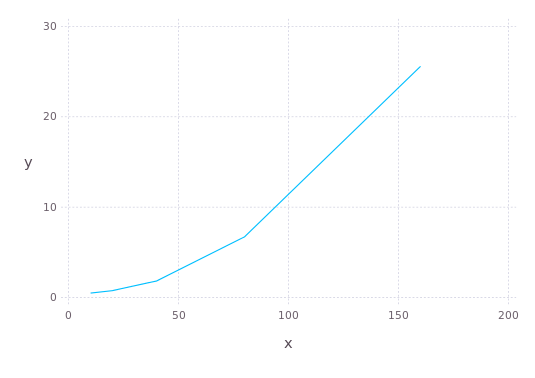

In [44]:
plot(x=n, y=time, Geom.line)

Growth is non-linear but not terrible. We might wait a couple of minutes for problem 3 to compute. Thankfully we have 16 2.5 Ghz cores.

# Problem 3 

In [14]:
L = [20, 50, 100, 200, 500, 1000]
forestSize = Array(Array{Float64,1}, length(L))
for i in 1:length(L)
 forestSize[i] = getAverageConnectedComponents(L[i], 100, p) / L[i]^2
end

In [18]:
using DataFrames

In [26]:
forests = DataFrame(Probability = [p:p:1], 
L20 = forestSize[1], 
L50 = forestSize[2], 
L100 = forestSize[3],
L200 = forestSize[4],
L500 = forestSize[5],
L1000 = forestSize[6]);

# a) 

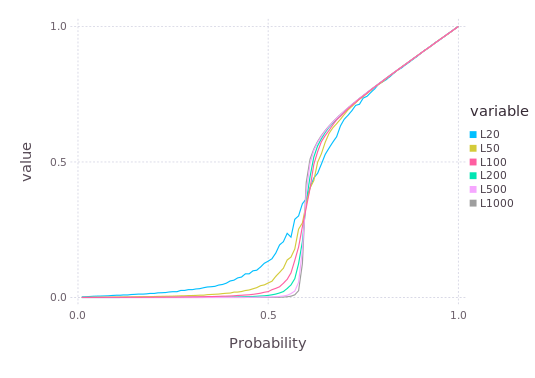

In [29]:
plot(melt(forests, :Probability), x = "Probability", y = "value", color = "variable", Geom.line)

# b)

We find that as $N \to \infty$ the curve defined by $S_{avg}$ as a function of probability becomes more severe; that is to say the critical probability approaches some limiting value. In this experiment our best estimate of the limiting value is $0.58$. 

# Problem 4 

In [62]:
function getDistribution(p, n)
 A = rand(n,n) .<= p
 groups = collect_groups(label_components(A))
 sizes = Array(Int, length(groups))
 for i in 1:length(groups)
 sizes[i] = length(groups[i])
 end
 sizes
end

getDistribution (generic function with 2 methods)

In [57]:
p = 0.58;

# a) 

In [77]:
pcrit = getDistribution(p, 5000);

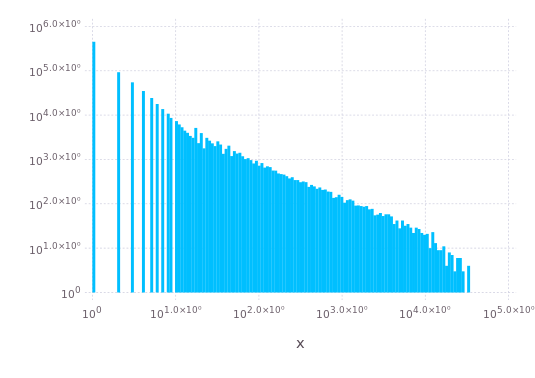

In [93]:
plot(x = pcrit, Geom.histogram, Scale.x_log10(format=:scientific, maxvalue = 10^5), 
Scale.y_log10(format=:scientific, maxvalue = 10^5))

The distribution of forest sizes is a power law with an exponent of about $1$.

# b) 

In [81]:
psmall = getDistribution(p / 2, 5000);

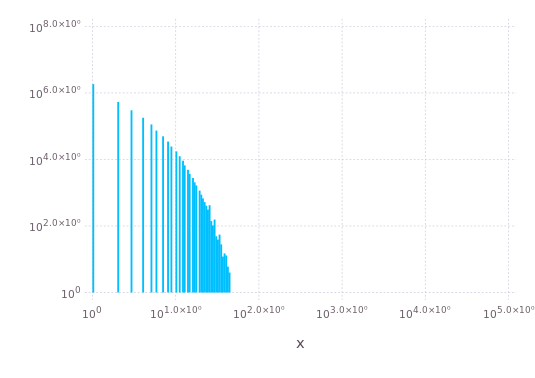

In [92]:
plot(x = psmall, Geom.histogram, Scale.x_log10(format=:scientific, maxvalue = 10^5), 
Scale.y_log10(format=:scientific, maxvalue = 10^5))

In [86]:
plarge = getDistribution(p + (1-p) / 2, 5000);

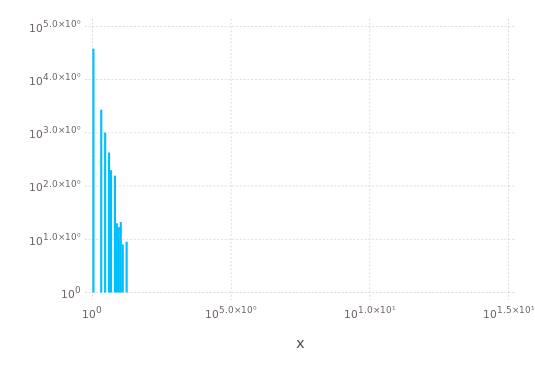

In [96]:
plot(x = plarge, Geom.histogram, Scale.x_log10(format=:scientific, maxvalue = 10^5), 
Scale.y_log10(format=:scientific, maxvalue = 10^5))

Note that the double logarithmic plot illustrates that neither distribution fit a power law well. These are not power laws.

# Problem 5 

In [4]:
n = 100

100

In [5]:
function sparkProbability(i::Int, j::Int, n::Int)
 l = n / 10
 #c = 1 / (l^2 * ( exp((-2n) / l) - 2 * exp(-(n + 1) / l) + exp(-2 / l) ))
 #c = ( exp(2(n + 1) / l) ) / ( l^2 * (exp(1 / l) - exp(n / l))^2 )
 exp(-i / l) * exp(-j / l)
end

sparkProbability (generic function with 1 method)

In [6]:
# Normalize and check normalization
cum = 0
for i = 1:n, j = 1:n
 cum = cum + sparkProbability(i, j, n)
end
c = 1 / cum

tot = 0
for i = 1:n, j = 1:n
 tot = tot + c * sparkProbability(i, j, n)
end
tot

0.9999999999999725

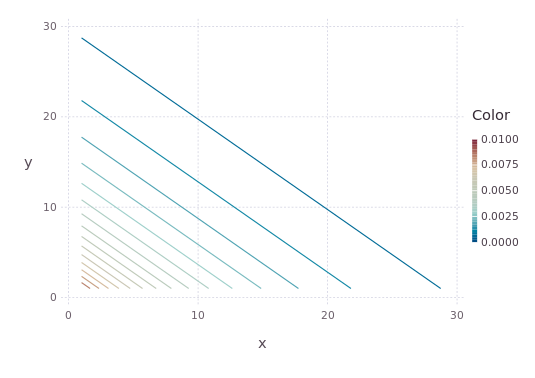

In [8]:
plot(z = (i,j) -> c * sparkProbability(convert(Int, ceil(i)), convert(Int, ceil(j)), n), 
x = [1:100], 
y = [1:100], 
Geom.contour )

Base.linspace(start, stop, n)

 Construct a vector of "n" linearly-spaced elements from "start"
 to "stop". See also: "linrange()" that constructs a range
 object.
